# Filesystem Data Analysis
### Nathan Tibbetts
### December 2019
### ACME Vol 3

## 1. Introduction
##### Description of the data, why it's interesting, and what I hope to find out.

The data we are using stems from file and folder metadata for all the files and folders on one computer. This means it contains over a million entries, each with some information about size, type, who it belongs to, how visible it is to the user, and how recently it was used.

This is interesting to me because I personally want to design a visual interface for filesystem trees, and need to understand how best to represent it, and what type of data we're dealing with, as well as what quantity. In the future I'd like to compare it to other computers' scraped filesystem data to see how much these values vary from computer to computer, and user type to user type. For now, however, we will restrict ourselves to answering just the few questions below.

**Specifically I want to learn:**
 - How big is the tree at each level.
 - What is the branching factor of the tree; how much does it grow in each generation down, and is this number lower or higher for roots vs. leaves, OS vs. User.
 - Does the branching factor generally change in different tree depths, and do file sizes.
 - How many files are commonly accessed by the user, and by the OS; i.e, How many files are "most important" to represent in an interface.
 - How many levels of the tree are commonly spanned by the most important or common files.
 - How are file sizes distributed.
 - In general, characteristics of the Userspace.
 - Can we visualize the tree yet; what would it look like.
 
While these questions and data are fairly abstract, they are just the sort of things I need to have a feel for before I can determine how to represent a user's files spatially in a graph, in a way that is distinct and easy to use.

## 2. Data Collection
##### Data source, methods used to gather, clean, and feature engineer it
**Source:** My personal laptop's filesystem. While this choice of source will clearly contain some bias in the userspace, as each user uses their system differently, it is sufficient to show what we want to show here, and indicate differences between OS space and user space. The processed and cleaned data is a little over one million files and folders, and takes up about 150 MB of space. An overview of features is given below.

We searched and were not able to find existing data of this sort on the internet. It likely exists, but if so much of it is probably proprietary, owned by Microsoft or Apple.

**Gathering & Cleaning:** We wrote a reusable Python script to figure out what the host OS is, walk the OS tree and stat each file, and compute some other things along the way, such as giving each node a unique index, pointing it to a parent, and reconstructing as many links as we could. We find whether files are hidden, what their modification and access dates are, whether they are files or folders, what their permissions are (and split this categorically into binary columns), etc. We also placed a slash after the path for directories, to visually differentiate as well when reading the data.

When scraping, we realized that the number of files would vary wildly (sometimes in the millions) between a computer with a long up-time versus one that has recently been rebooted. This causes us to need to define a term, "ghost file", to represent all such transient files deep in the OS that change when you reboot the computer, or others that have weird properties like representing a mounted peripheral instead of actually taking up disk space, or those that represent segments of RAM instead of the non-volatile disk drive, or other oddities, etc. These skew the numbers somewhat, but this is exactly part of what we want to know about how an OS uses the directory tree. In the future we may harvest up-time data and correllate number of files with this value, but this is beyond the scope of the current project.

We know from the scraping and cleaning process that there are a few remaining issues with broken link files in the OS space, and were not able to determine where these links pointed to. However, since these are likely deep OS or ghost files, or links to similarly deep areas, this is not a concern for us here. So, whereas non-links link to node "-1", we instead left a designation of "-2" where a broken link occurred so we could count them if need be.

**Feature Engineering:**
 - We processed OS timestamps into how recently files were used as a representation of their relative importance, or frequency of use.
 - We removed columns we wouldn't need for this project.
 - We computed whether each file or folder is a "Desktop" folder, is in a Desktop folder, or is in the User directory (assumed to be the Desktop's parent) as a measure of importance to the user or being within Userspace. We first split this categorically into binary columns, then changed our minds since it was not to be correllated with any other columns, and could better be used to color points on a graph if it was categorical in a single column.
 - We compute whether each is *subsidiary* to a hidden directory, not just hidden itself, as these will also typically be invisible to the user.
 - We added a column representing the $log_2$ of file sizes (setting log-sizes of 0 as -1 for graphability) because of the wide range of sizes, and because this improves readability as it relates to KB, MB, GB, etc.
 - We computed each node's number of children and its depth in the tree, for tree analysis.
 - Perhaps most importantly, we made a boolean column designating whether a file or folder was in the Userspace or the OS Space - a moderately good approximation based on whether or not it is found in the user folder, visible or not subsidiary to a hidden folder, user-editable, and is actually a file or folder and not an "irregular" file. This is not perfect, but slims it down enough to mostly contain user data and show us the differences between OS and User space. The purpose of this was to study how the User uses the tree differently from the OS, and because we're most concerned about learning how we can well-represent the User's data visually in an interface.

**Data Validity:** Other than broken links, some of our engineered data could potentially contain bugs, but many were found and fixed along the way and what is left appears very sound. As for the original data, since it was all scraped computationally it is technically "correct", even if it contains some oddities we had to deal with. We noticed that some OS files have access or modify dates occurring in the future - surely some oddity of linux. There are also the broken links, of course, and the imperfect designation between OS and User space.

**Future work:** In the future, we want to compile a database of the same statistics we find here, except across and comparing many filesystems, so that we can see variance across user space, as well as be able to compare the trends of different operating systems within their OS space. This would be particularly interesting information to know in designing an interface, but is beyond the scope of this project.

## 3. Data Visualization
##### Plots and Analyses of the Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import datetime
import statsmodels.api as sm
import seaborn as sns

In [5]:
# Read in our data file, show its columns
data = pd.read_pickle("data0.pkl")
data.columns

Index(['Parent', 'Size', 'Is Directory', 'Is Regular File', 'Is Link To',
       'Desktop', 'Path', 'Irregular', 'Userspace', 'Recency',
       'Modification Recency', 'Child Count', 'Depth', 'Size Log2'],
      dtype='object')

In [6]:
# Partition the data into user space versus OS space
userspace = data[data.Userspace == 1]#.drop("Userspace", axis=1) # Screws with indices if we drop it.
osspace   = data[data.Userspace == 0]#.drop("Userspace", axis=1)
print("Size of User Space:", len(userspace))
print("Size of OS   Space:", len(osspace))

# Define some constants for use later
cols = list(data.columns)
P = cols.index("Parent")
D = cols.index("Is Directory")
F = cols.index("Is Regular File")
L = cols.index("Is Link To")
DESK = cols.index("Desktop")
DEPTH = cols.index("Depth")
C = cols.index("Child Count")

Size of User Space: 72708
Size of OS   Space: 935976


We have successfully slimmed down a selection that we presume is a fair representation of the userspace. While not great and certainly contains some OS files found within the user directories, it should be sufficient to show what we want to show here, and highlight the differences betwen OS and user space. Note it is most likely still sufficiently many to be statistically effective.

### How big is the tree at each level?

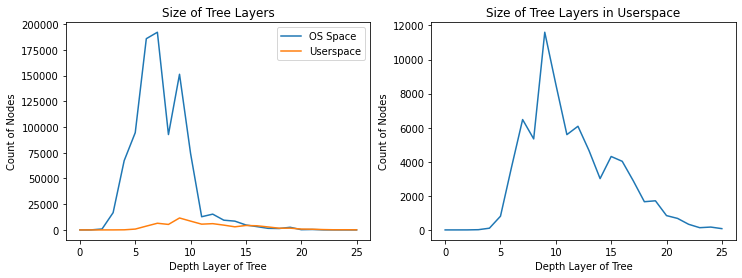

In [7]:
### Show num nodes per depth level; compare OS and user space.

# Compute depth counts
os_depth_counts   = [0 for d in range(max(data.Depth)+1)]
user_depth_counts = [0 for d in range(len(os_depth_counts))]
for row in osspace.values:           # Can't do list comprehension;
    os_depth_counts[row[DEPTH]] += 1 #   changing multiple asynchonously.
for row in userspace.values:
    user_depth_counts[row[DEPTH]] += 1
    
# Plot them
fig=plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Size of Tree Layers")
plt.ylabel("Count of Nodes")
plt.xlabel("Depth Layer of Tree")
plt.plot(range(len(os_depth_counts)), os_depth_counts, label="OS Space")
plt.plot(range(len(user_depth_counts)), user_depth_counts, label="Userspace")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Size of Tree Layers in Userspace")
plt.ylabel("Count of Nodes")
plt.xlabel("Depth Layer of Tree")
plt.plot(range(len(user_depth_counts)), user_depth_counts)
plt.show()

This is a simple graph describing how large each layer of the tree actually is, to give us some context for the next couple of graphs. Clearly the mid-upper levels are the most populated in the OS space, and the middle areas in the userspace.

### What is the branching factor of the tree?

### Are there more folder or file children?

### Is the branching factor different in OS vs. User space?

Max children, Userspace: 6833 OS Space: 15329
Avg children, Userspace: 8.92918192918193 OS Space: 12.294539720086734
Children std, Userspace: 84.91782778453143 OS Space: 76.46216518166185
Max children, Files: 15329 Folders: 1938
Avg children, Files: 10.818547283180358 Folders: 3.7250797892080456
Children std, Files: 79.36969296677049 Folders: 20.659279060319523
Folders without children: 16091

These are truncated with outliers placed in the final bin,
  and skipping those without children to make the graph readable,
  since no files have children, and some folders don't:


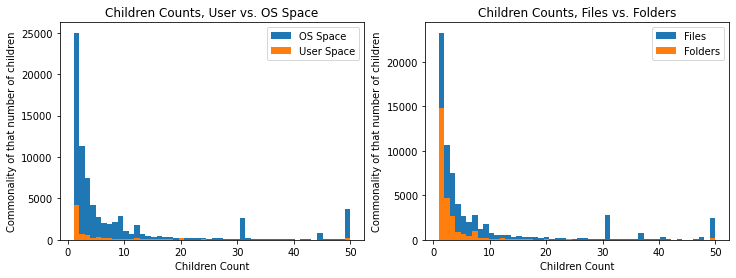

In [8]:
### What is the branching factor of the tree;
#   how much does it grow in each generation down,
#   and are there more folder or file children,
#   and is the branching factor different in OS vs. User space?

# Compute how many children each node has
folder_counts = {}
file_counts = {}
for row in data.values:
    if row[D]:
        if row[P] in folder_counts: folder_counts[row[P]] += 1
        else: folder_counts[row[P]] = 1
    elif row[F]:
        if row[P] in file_counts: file_counts[row[P]] += 1
        else: file_counts[row[P]] = 1

folder_counts = list(folder_counts.values())
file_counts   = list(file_counts.values())
user_counts   = [v for v in userspace["Child Count"].values if v > 0]
os_counts     = [v for v in osspace["Child Count"].values   if v > 0]

# Report some numbers
print("Max children, Userspace:", np.max(user_counts), "OS Space:", np.max(os_counts))
print("Avg children, Userspace:", np.mean(user_counts), "OS Space:", np.mean(os_counts))
print("Children std, Userspace:", np.std(user_counts), "OS Space:", np.std(os_counts))
print("Max children, Files:", np.max(file_counts), "Folders:", np.max(folder_counts))
print("Avg children, Files:", np.mean(file_counts), "Folders:", np.mean(folder_counts))
print("Children std, Files:", np.std(file_counts), "Folders:", np.std(folder_counts))
print("Folders without children:", sum(data[data["Is Directory"] == 1]["Child Count"] == 0))

# Cap things for the sake of readable histograms
CAP = 50
user_counts   = [CAP if v > CAP else v for v in user_counts  ]
os_counts     = [CAP if v > CAP else v for v in os_counts    ]
folder_counts = [CAP if v > CAP else v for v in folder_counts]
file_counts   = [CAP if v > CAP else v for v in file_counts  ]

# Print some info
print("\nThese are truncated with outliers placed in the final bin,\n  and skipping those without children to make the graph readable,\n  since no files have children, and some folders don't:")

# Plot histograms
fig=plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Children Counts, User vs. OS Space")
plt.xlabel("Children Count")
plt.ylabel("Commonality of that number of children")
plt.hist(os_counts, bins=CAP, label="OS Space")
plt.hist(user_counts, bins=CAP, label="User Space")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Children Counts, Files vs. Folders")
plt.xlabel("Children Count")
plt.ylabel("Commonality of that number of children")
plt.hist(file_counts, bins=CAP, label="Files")
plt.hist(folder_counts, bins=CAP, label="Folders")
plt.legend()
plt.show()

These plots show us approximately the distribution of how many files/folders are contained in each folder. We have not shown those files/folders with no children here, to make the histograms readable; it is a very large number in comparison to what we see here. We can see spikes at around 30 and 50, surely some oddity within the OS space where there are several folders with the same number of files.

**The first graph** shows us that while the distribution is of the same type, it is much more skewed at 1 child, and perhaps more evenly spread thereafter.

**The second graph** shows us that the distribution is similar between the number of files each folder contains, and the number of folders it contains, though the quantity is different.

**The statistics given above the graphs** sum things up nicely; we can see that the branching factor, or average child count, in the OS space is a little larger than in the userspace, and is around 9 in userspace, with an enormous variance around the board. This helps me visualize what a graph of the directory tree should look like, and about how many children each node should have if we were to draw it.

**In future work** these could be used potentially to model randomly generated realistic filesystems, though this is beyond the scope of our interests here.

### Does the branching factor change in different tree depths?

Userspace depths, Min: 2, Max: 25, Avg: 11.403009297463829
OS Space  depths, Min: 0, Max: 23, Avg: 7.3757126251100456
All       depths, Min: 0, Max: 25, Avg: 7.666008383200289


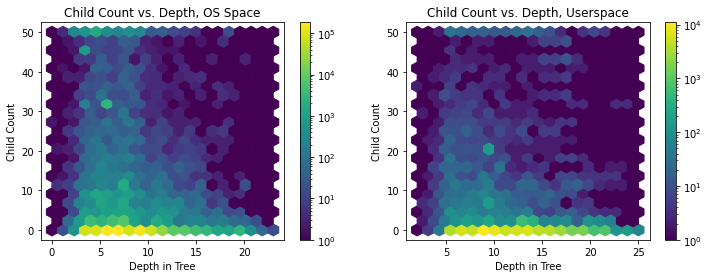

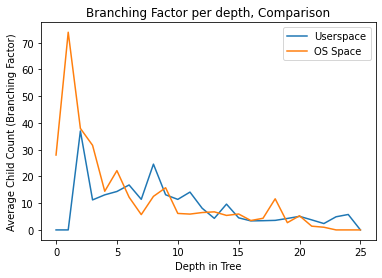

In [9]:
### Does the branching factor change in different tree depths?
### Also, some characteristics of the Userspace vs. whole system

# Some stats
print(f"Userspace depths, Min: {min(userspace.Depth)}, Max: {max(userspace.Depth)}, Avg: {np.mean(userspace.Depth)}")
print(f"OS Space  depths, Min: {min(osspace.Depth)}, Max: {max(osspace.Depth)}, Avg: {np.mean(osspace.Depth)}")
print(f"All       depths, Min: {min(data.Depth)}, Max: {max(data.Depth)}, Avg: {np.mean(data.Depth)}")

# Compute average child counts for each layer of the tree
os_depths = [[] for _ in range(max(data.Depth)+1)]
user_depths = [[] for _ in range(len(os_depths))]
for row in osspace.values:
    if row[C]: os_depths[row[DEPTH]].append(row[C])
for row in userspace.values:
    if row[C]: user_depths[row[DEPTH]].append(row[C])
os_depths   = [np.mean(l) if len(l) else 0 for l in os_depths  ]
user_depths = [np.mean(l) if len(l) else 0 for l in user_depths]

# Plot OS Space hexbins
fig=plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
children = np.minimum(osspace["Child Count"], CAP)
plt.title("Child Count vs. Depth, OS Space")
plt.xlabel("Depth in Tree")
plt.ylabel("Child Count")
plt.hexbin(osspace.Depth, children, gridsize=20, norm=matplotlib.colors.LogNorm())
plt.colorbar()

# Plot Userspace hexbins
plt.subplot(1, 2, 2)
user_children = np.minimum(userspace["Child Count"], CAP)
plt.title("Child Count vs. Depth, Userspace")
plt.xlabel("Depth in Tree")
plt.ylabel("Child Count")
plt.hexbin(userspace.Depth, user_children, gridsize=20, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

# Comparison to show how branching factor changes per depth
plt.title("Branching Factor per depth, Comparison")
plt.xlabel("Depth in Tree")
plt.ylabel("Average Child Count (Branching Factor)")
plt.plot(range(len(user_depths)), user_depths, label="Userspace")
plt.plot(range(len(os_depths)), os_depths, label="OS Space")
plt.legend()
plt.show()

**The stats printed above** these graphs show that the userspace on average spans more layers of the tree than does the OS space, by just a few levels.

**The hexbin plots** are a good visualization of the distribution of child counts per depth. Note that they have been truncated so that anything with more than 50 children is placed in the last row of bins; hence the top row appears more dense than it otherwise would. This means these plots describe nice, if a little extreme, distributions. The first hexbin plot, compared to the second, shows that the userspace's distribution is a bit more skewed towards the bottom (fewer children), while the OS distribution is a little more skewed to the left (lower in the tree).

**The last plot** shows a comparison in userspace vs. OS space describing how the *Average* number of children changes with depth in the tree. Since we can equate "average children" with "branching factor", this shows us that the branching factor of the tree significantly changes, decreases generally, as we go deeper into the tree's layers. This is interesting, as this is perhaps the opposite of what I would have expected. Also, due to less nodes on the earliest and later depth levels, the left and right sides of this graph are slightly less meaningful.

### Do file sizes change in different tree depths?

In [10]:
### Do file sizes change in different tree depths
sm.OLS(data.Depth, data["Size Log2"]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Depth   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.695
Method:                 Least Squares   F-statistic:                          2.294e+06
Date:                Tue, 18 May 2021   Prob (F-statistic):                        0.00
Time:                        12:46:16   Log-Likelihood:                     -2.9484e+06
No. Observations:             1008684   AIC:                                  5.897e+06
Df Residuals:                 1008683   BIC:                                  5.897e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Size Log2      0.6990      0.000   1514.469      0.000       0.698       0.700
==============================================================================
Omnibus:                    15110.394   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16996.785
Skew:                           0.262   Prob(JB):                         0.00
Kurtosis:                       3.361   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Depth', ylabel='Size Log2'>

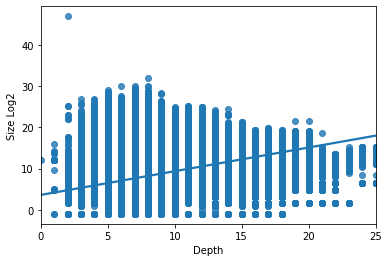

In [11]:
sns.regplot(x='Depth', y='Size Log2', data=data[["Depth", "Size Log2"]])

By this graph we can see that file sizes generally get larger as we go deeper into the tree, as given by the linear regression line. Remember that $2^{20}$B is 1MB, and $2^{10}$B is 1KB. With more time, we might be able to show the actual change in average sizes over depth, as we have done with child counts.

This, together with the generally greater number of files occurring in midrange depth of the tree would make it difficult for an interface showing the tree to properly display files according to their size. I expected such would be difficult anyway, but it is good information to know.

### How many files are commonly accessed by the user, and by the OS; i.e, How many files are "most important" to represent in an interface?

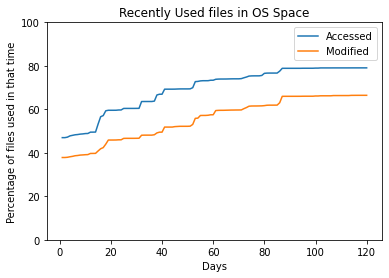

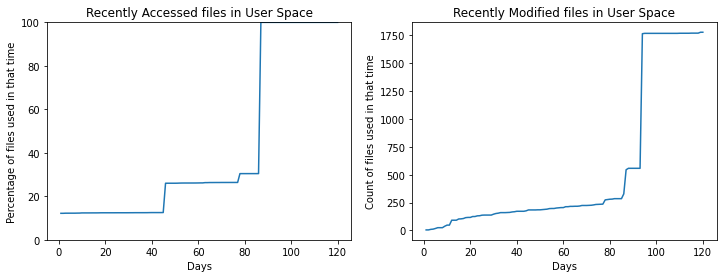

User total               modified in one month:   152
User total/files/folders modified in two months:  213 155 50


In [12]:
### How many files are commonly accessed by the user, and by the OS;
#   i.e, How many files are "most important" to represent in an interface

# Compute recency amounts
DAYS = 120
age = [datetime.timedelta(days=n) for n in range(1,DAYS+1)]
os_times = np.array([sum(osspace.Recency < a) for a in age])
user_times = np.array([sum(userspace.Recency < a) for a in age])
os_times2 = np.array([sum(osspace["Modification Recency"] < a) for a in age])
user_times2 = np.array([sum(userspace["Modification Recency"] < a) for a in age])

# Plot
plt.title("Recently Used files in OS Space")
plt.xlabel("Days")
plt.ylabel("Percentage of files used in that time")
plt.ylim(0, 100)
plt.plot(range(1, DAYS+1), 100*os_times/len(osspace), label="Accessed")
plt.plot(range(1, DAYS+1), 100*os_times2/len(osspace), label="Modified")
plt.legend()
plt.show()

fig=plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Recently Accessed files in User Space")
plt.xlabel("Days")
plt.ylabel("Percentage of files used in that time")
plt.ylim(0, 100)
plt.plot(range(1, DAYS+1), 100*user_times/len(userspace))

plt.subplot(1, 2, 2)
plt.title("Recently Modified files in User Space")
plt.xlabel("Days")
plt.ylabel("Count of files used in that time")
plt.plot(range(1, DAYS+1), user_times2)
plt.show()

print("User total               modified in one month:  ", user_times2[30])
print("User total/files/folders modified in two months: ", user_times2[60],
     sum(userspace[userspace["Is Regular File"] == True]["Modification Recency"] < datetime.timedelta(days=60)),
     sum(userspace[userspace["Is Directory"]    == True]["Modification Recency"] < datetime.timedelta(days=60)),)

Notice the first two graphs are percentages - this represents an enormous number of files accessed or modified. The third graph is labeled with explicit numbers on the y-axis, as they are much more manageable numbers.

An analysis of these graphs, as well as checking which files are being used, shows that most file/folder accesses are done by the OS, since a user does not typically access so many files regularly. The huge percentage jumps are likely the OS indexing them, as the user can only go through so many things at once themselves by hand. In fact, this means that our data regarding recency of access is essentially useless in the User Space, and and so we look instead at modification dates.

We can see an anomaly in the modification of files in the User Space of this filesystem, corresponding probably to the user copying over a large number of files from an external backup or some similar thing. Since this type of jump does not appear before 80 days, we can safely presume that the modification dates newer than 80 days here will be an accurate description of day-to-day file usage volume for a user. This is useful for someone designing a big-picture sort of interface intended to show the most commonly used things more prominently.

### How many levels of the tree are commonly spanned by the most important or common files?

In [13]:
### How many levels of the tree are commonly spanned by the most important or common files,
#   and other stats about them.

# Most important chunk of userspace files
important = userspace[userspace["Modification Recency"] < datetime.timedelta(days=80)]
m, M = min(important.Depth), max(important.Depth)
print(f"Count of most important, Total: {len(important)}, Desktop: {sum(important.Desktop > 1)}")
print(f"Depth of most important, Min: {m}, Max: {M}, Range: {M-m}")
print(f"Max child count of most important: {max(important['Child Count'])}")
print(f"Log2(avg file size) of most important: {np.log(np.mean(important.Size))/np.log(2)}")

Count of most important, Total: 280, Desktop: 6
Depth of most important, Min: 2, Max: 10, Range: 8
Max child count of most important: 90
Log2(avg file size) of most important: 22.46431732131838


### How are file sizes distributed?

For our purposes, as we don't have a need to model the randomness of the data yet, some histograms will do:

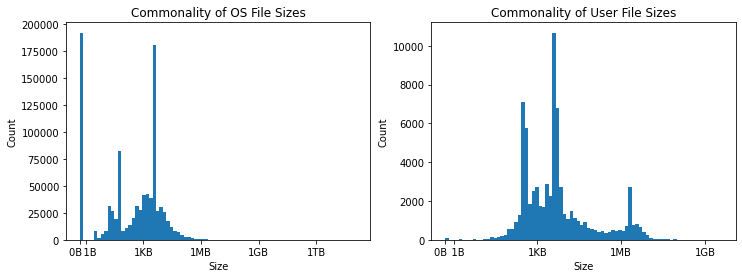

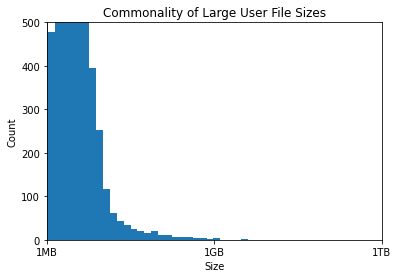

In [27]:
fig=plt.figure(figsize=(12, 4))

# Plot for OS file sizes
plt.subplot(1,2,1)
plt.title("Commonality of OS File Sizes")
plt.ylabel("Count")
plt.xlabel("Size")
plt.xticks([-1, 0, 10, 20, 30, 40], ["0B   ", "   1B", "1KB", "1MB", "1GB", "1TB"])
plt.hist(osspace["Size Log2"], bins=80)

# Plot for user file sizes
plt.subplot(1,2,2)
plt.title("Commonality of User File Sizes")
plt.ylabel("Count")
plt.xlabel("Size")
plt.xticks([-1, 0, 10, 20, 30, 40], ["0B   ", "   1B", "1KB", "1MB", "1GB", "1TB"])
plt.hist(userspace["Size Log2"], bins=80)

plt.show()

# Plot for bigger user file sizes
plt.title("Commonality of Large User File Sizes")
plt.ylabel("Count")
plt.xlabel("Size")
plt.xticks([-1, 0, 10, 20, 30, 40], ["0B   ", "   1B", "1KB", "1MB", "1GB", "1TB"])
plt.xlim(20, 40)
plt.ylim(0, 500)
plt.hist(userspace["Size Log2"], bins=80)

plt.show()

These graphs represent commonality of file sizes in OS and user space. We'll break these down a bit.

Notice the spike in both graphs at 4KB. This is likely due to the fact that folder objects themselves generally have a set size of 4096 bytes, or 4KB, regardless of what they may contain.

You will also notice the spike in the OS graph at 0 bytes - due most likely to they myriad of ghost OS files which are often used to represent virtual memory objects, mounted disk or drive objects, peripherals, etc. in the Linux system.

Also, there is a somewhat more confusing spike in both graphs at around 32-128 bytes; this may also be due to small (non-zero-sized) OS files, such as are used in representing virtual memory page properties etc. It is also good to be aware that files may have a minimum block file size, so the first few bars after 1B may not be accurate representations of the small amount of data these files contain. In any case, this final, shortest spike may be a legitimate part of the distribution and not a special case.

Lastly, there is a spike in the userspace graph at around 2-4 megabytes. This is likely due to the large number of audio files and photographs which characterizes almost any user's personal computer.

Besides the spikes, I find it extremely interesting that we have a bimodal distribution in the OS space, and what's more, a trimodal graph in the user space. I can only presume that it is far more likely to have "tiny" files or "small", or even "large" files, than to have anything in-between. Many log files or word documents will be in the range of kilobytes, and many OS files will have just a tiny entry (of which there are still a few hiding in our imperfectly defined user space). Likewise, many videos, games, and programs will be in the range of several megabytes.

In future work we could model pdf's off of these, but we would most likely need data from more filesystems so as not to contain the biases of a single user here. In any case, this is beyond the scope of our current needs.

### Can we visualize the tree, yet? What would it look like?

In [24]:
### Visualize most important
# NOTE: We were going to produce a visualization of more than this,
#       but even the contents of the desktop are too much
#       for our poor current method of using networkx.

# Visualization Creation
colorset = {1:"#0000ff", 2:"#00ff00", 3:"#ff0000"}
G = nx.Graph()
vertices = set(important.index)
edges = [(important.index[i], row[P]) for i, row in enumerate(important.values) if row[P] in vertices]
edge_colors = ['#000000'] * len(edges)
edges2 = [(important.index[i], row[L]) for i, row in enumerate(important.values) if row[L] in vertices]
edge_colors += ['#00ff00'] * len(edges2)
edges += edges2
colors = [colorset[row[DESK]] for row in important.values]
G.add_nodes_from(important.index)
G.add_edges_from(edges)

# Plot it
fig=plt.figure(figsize=(12, 8))
nx.draw_networkx(G, node_color=colors, node_size=(important["Size Log2"]+2),
                 with_labels=False, edge_colors=edge_colors)

ValueError: Received invalid argument(s): edge_colors

<Figure size 864x576 with 0 Axes>

Imagine this, only times 4000. The above is a representation of only the most recently used important parts of the userspace, around 280 files/folders. They appear disconnected because some of their connecting parents do not fit into this category, with our chosen method.

The red node is the Desktop folder itself, and the green nodes are items within the desktop. Most of the files commonly used on this system are in the User and Documents folders, more or less adjacent in the tree to the Desktop, and containing it. Sizes of nodes are relative to their Log2 size. If there were any links, those edges would be marked green.

We could not, with current available resources, graph tens or hundreds of thousands of nodes. But what we do have looks pretty. Of course, in order to make a proper user interface, it would have to be readable - you'd have to be able to tell what each node was. That, however, is a problem for another day.

## 4. Conclusion
##### The main takeaways from my analysis

After doing this analysis of a single filesystem, I have a much better intuition about how it is organized, how it works, and how one might be able to visualize it. This was, essentially, the goal. We were able to answer the specific questions we chose to focus on, with striking visual results.

When I go to design a filesystem interface to replace the common folder explorer, I will know approximately how much I can show on the screen at once. I can, from here, estimate how many layers, how many files and folders in each layer, and how much space it will take up. And the result is that I truly think I can do it - it is possible to show the amount I want to show, and now I know there's nothing to stop me. I can represent a lot on the screen without it becoming a mess. It will not be easy, however. I will have to balance how much is shown in each layer, and how much is compressed visually. It will be a later work to figure out how much is *optimal* to show, from a usability and readability standpoint.

Future Work, or things to learn how to answer later:
 - How clustered are similarly sized files.
 - How clustered are highly used files in a file system, particularly in userspace.
 - How difficult is it to represent all of the most important parts of the OS at once.
 - Produce a graph visualization of the most used/important parts of the userspace.
 - Find probability distributions to estimate file sizes and counts at different levels of the tree.
 - How big are commonly accessed / user files versus rare or OS ones.
 - What types (extensions) are most commonly used.
 - Compare these stats across many filesystems, users, and operating systems.